In [26]:
%matplotlib inline
import boto3
import botocore
import os.path
import xarray as xr
import datetime

import numpy as np
import pandas as pd
import xarray as xr
from dateutil.relativedelta import relativedelta
import pickle
from matplotlib import animation, pyplot as plt
from pathlib import Path
import calendar
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from imblearn.over_sampling import SMOTE

import seaborn as sns

In [27]:
# Specify your longitude and latitude range
lats = slice(25, 0)
lons = slice(70, 80)

# Initialize a list to store the data
data_list = []

# Iterate over the years and months
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2023-5-31')

curr_date = start_date
while curr_date <= end_date:
    year = curr_date.year
    month = curr_date.month
    
    # Get the number of days in the month
    _, num_days = calendar.monthrange(year, month)
    
    # Construct the file path
    file_path = f'/home/jovyan/shared/data_sst/{year}{month:02d}_sea_surface_temperature.nc'
    
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f'File not found: {file_path}. Skipping this month.')
        curr_date += relativedelta(months=1)
        continue
    
    # Open the dataset
    ds = xr.open_dataset(file_path)
    
    # Select the time points
    time_points = pd.date_range(start=f'{year}-{month:02d}-01T09:00:00', end=f'{year}-{month:02d}-{num_days}T09:00:00', freq='D')
    ds_selected_time = ds.sel(time0=time_points, method='nearest')
    
    # Select the longitude and latitude
    ds_selected = ds_selected_time.sel(lon=lons, lat=lats)
    
    # Get the sea_surface_temperature values
    sst_data = ds_selected['sea_surface_temperature'].values
    sst_data = np.expand_dims(sst_data, axis=-1)

    # Append the data to the list
    data_list.append(sst_data)
    
    # Move to the next month
    curr_date += relativedelta(months=1)
    
    # Print a message
    print(f'Successfully processed data for: {year}-{month:02d}')

# Concatenate all the data
sst_data = np.concatenate(data_list, axis=0)

print(sst_data.shape)

Successfully processed data for: 2015-01
Successfully processed data for: 2015-02
Successfully processed data for: 2015-03
Successfully processed data for: 2015-04
Successfully processed data for: 2015-05
File not found: /home/jovyan/shared/data_sst/201506_sea_surface_temperature.nc. Skipping this month.
Successfully processed data for: 2015-07
Successfully processed data for: 2015-08
Successfully processed data for: 2015-09
Successfully processed data for: 2015-10
Successfully processed data for: 2015-11
Successfully processed data for: 2015-12
Successfully processed data for: 2016-01
Successfully processed data for: 2016-02
Successfully processed data for: 2016-03
Successfully processed data for: 2016-04
Successfully processed data for: 2016-05
Successfully processed data for: 2016-06
Successfully processed data for: 2016-07
Successfully processed data for: 2016-08
Successfully processed data for: 2016-09
Successfully processed data for: 2016-10
Successfully processed data for: 2016-

In [57]:
sst_data.shape

(3014, 101, 41, 1)

In [28]:
processed_data_list = []

for day_data in sst_data:
    day_data = np.squeeze(day_data)
    
    day_data = np.flipud(day_data)
    
    sst_data2 = np.nanmean(day_data)
    
    sst_data3 = day_data - sst_data2
    
    processed_data_list.append(sst_data3)

processed_data = np.array(processed_data_list)

In [58]:
processed_data.shape

(3014, 101, 41)

In [29]:
processed_data_reshaped = processed_data.reshape((processed_data.shape[0], -1))
SST_DATA = np.nan_to_num(processed_data_reshaped, nan=0.0)

In [30]:
start_year = 2015
end_year = 2023

# List to store all group labels
all_labels = pd.Series(dtype=int)

# Process each year
for year in range(start_year, end_year + 1):
    # Process each month
    for month in range(1, 13):
        if year == 2023 and month > 5:
            break
        file_name = f"/home/jovyan/shared/SST_Diff/{year}{month:02d}_sst_diff.nc"
        if not Path(file_name).exists():
            print(f"File {file_name} does not exist, skipping...")
            continue
        print(f"Processing file {file_name}...")

        # Open the dataset and convert it to a pandas DataFrame
        temp = xr.open_dataset(file_name)
        temp_df = temp.to_dataframe()

        # Convert the 'time' column to date only format
        temp_df.index = pd.to_datetime(temp_df.index).date

        # Reset index to create 'time' column
        temp_df = temp_df.reset_index()

        # Create a new column 'entry_id' which enumerates each entry within each date
        temp_df['entry_id'] = temp_df.groupby('time').cumcount()

        # Filter dataframe for rows where 'entry_id' is 22 and 23, and create a copy
        filtered_df = temp_df[temp_df['entry_id'].isin([22,23])].copy()

        # Create a label column - set to 1 if SST_Diff < threshold, else set to 0
        threshold = -1
        filtered_df.loc[:, 'label'] = np.where(filtered_df['SST_Diff'] < threshold, 1, 0)

        # Group by 'time' and check if all 'label' in a group is 1, if so, set group_label to 1, else 0
        group_labels = filtered_df.groupby('time')['label'].apply(lambda x: 1 if x.sum() == 2 else 0)

        # Append the group_labels to all_labels
        all_labels = pd.concat([all_labels, group_labels])
print(all_labels.shape)

Processing file /home/jovyan/shared/SST_Diff/201501_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/201502_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/201503_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/201504_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/201505_sst_diff.nc...
File /home/jovyan/shared/SST_Diff/201506_sst_diff.nc does not exist, skipping...
Processing file /home/jovyan/shared/SST_Diff/201507_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/201508_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/201509_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/201510_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/201511_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/201512_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/201601_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/201602_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/201

In [31]:
all_labels_reshaped = all_labels.values.ravel()

In [32]:
print("Shape of sst_data_reshaped: ", SST_DATA.shape)
print("Shape of all_labels_reshaped: ", all_labels_reshaped.shape)

Shape of sst_data_reshaped:  (3014, 4141)
Shape of all_labels_reshaped:  (3014,)


In [33]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Masking
from keras.regularizers import l1_l2
from tqdm.keras import TqdmCallback

# Reshape data for SMOTE
sst_data_flat = SST_DATA.reshape(SST_DATA.shape[0], -1)

# Apply SMOTE
smote = SMOTE(random_state=42)
sst_data_res, labels_res = smote.fit_resample(sst_data_flat, all_labels_reshaped)

# Reshape the data to original shape
sst_data_res = sst_data_res.reshape((sst_data_res.shape[0], -1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sst_data_res, labels_res, test_size=0.2, random_state=42)

# Define the model
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], 1)))
model.add(LSTM(150, activation='tanh', return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))  # Increase number of LSTM units and add L1L2 regularization
model.add(Dropout(0.2))  # Add dropout layer for regularization
model.add(LSTM(100, activation='tanh', return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))  # Add another LSTM layer and add L1L2 regularization
model.add(Dropout(0.2))  # Add dropout layer for regularization
model.add(LSTM(50, activation='tanh', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))  # Add another LSTM layer and add L1L2 regularization
model.add(Dropout(0.2))  # Add dropout layer for regularization
model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))  # Increase Dense layer units and add L1L2 regularization
model.add(Dropout(0.2))  # Add dropout layer for regularization
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

tqdm_callback = TqdmCallback(verbose=1)

# Train the model
model.fit(X_train, y_train, epochs=50, verbose=0, callbacks=[tqdm_callback])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

34/34 [==============================] - 66s 2s/step - loss: 0.3998 - accuracy: 0.8264
Accuracy: 0.8264151215553284


In [34]:
# Start date
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2023-5-31')
excluded_months = ['198304', '198802', '199209', '199702', '200111', '200604', '201102', '201506', '202002']

# Initialize an empty list to store the rows of the DataFrame
data = []

# Initialize the current index of sst_data and all_labels_reshaped
curr_index = 0

# Iterate over the dates
curr_date = start_date
while curr_date <= end_date:
    year_month = curr_date.strftime('%Y%m')
    if year_month in excluded_months:
        _, num_days = calendar.monthrange(curr_date.year, curr_date.month)
        curr_index += num_days
        curr_date += relativedelta(months=1)
        continue
    _, num_days = calendar.monthrange(curr_date.year, curr_date.month)
    for _ in range(num_days):
        # Check if the current index is out of bounds
        if curr_index >= len(all_labels_reshaped):
            break
        # Get the actual value
        actual_val = all_labels_reshaped[curr_index]

        # Get the prediction
        day_data = SST_DATA[curr_index].reshape(1, -1, 1)
        prediction = model.predict(day_data)

        # Append the data to the list
        data.append({'time': curr_date, 'actual_val': actual_val, 'predicted_val': prediction})

        # Increase the current index and the current date
        curr_index += 1
        curr_date += pd.DateOffset(days=1)

    # Exit the loop if the current index is out of bounds
    if curr_index >= len(all_labels_reshaped):
        break

# Create the DataFrame
df = pd.DataFrame(data)

# Check the DataFrame
print(df)

1/1 [==============================] - 1s 700ms/step
           time  actual_val       predicted_val
0    2015-01-01           0   [[0.00010117421]]
1    2015-01-02           0   [[0.00010119833]]
2    2015-01-03           0  [[0.000101202866]]
3    2015-01-04           0  [[0.000101212325]]
4    2015-01-05           0   [[0.00010118251]]
...         ...         ...                 ...
2950 2023-03-29           0      [[0.41175857]]
2951 2023-03-30           0      [[0.73029244]]
2952 2023-03-31           0       [[0.7775213]]
2953 2023-04-01           0       [[0.5847521]]
2954 2023-04-02           0       [[0.7588688]]

[2955 rows x 3 columns]


In [56]:
print(len(df[(df['actual_val'] == 0) & (df['predicted_val'] > 0.73)]))
print(len(df[(df['actual_val'] == 0)]))
print(len(df[(df['actual_val'] == 1) & (df['predicted_val'] > 0.73)]))
print(len(df[(df['actual_val'] == 1)]))

516
2610
303
345


/tmp/ipykernel_42979/848147468.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_0['predicted_val'], label='actual_val=0', kde=False)
/tmp/ipykernel_42979/848147468.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_1['predicted_val'], label='actual_val=1', kde=False)


Text(0, 0.5, 'Density')

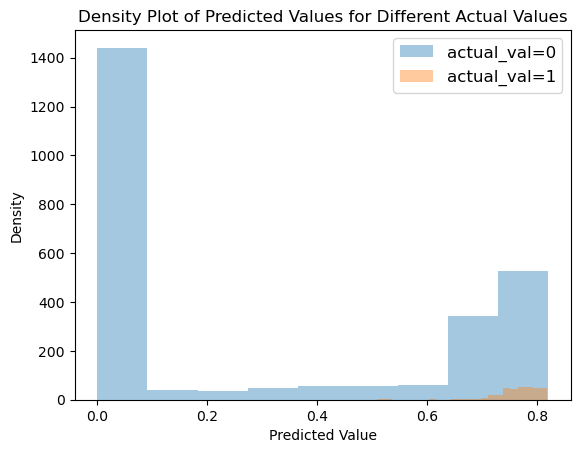

In [49]:
df_0 = df[df['actual_val'] == 0]
df_1 = df[df['actual_val'] == 1]

sns.distplot(x=df_0['predicted_val'], label='actual_val=0', kde=False)

sns.distplot(x=df_1['predicted_val'], label='actual_val=1', kde=False)

plt.legend(prop={'size': 12})
plt.title('Density Plot of Predicted Values for Different Actual Values')
plt.xlabel('Predicted Value')
plt.ylabel('Density')


In [48]:
model.save('LSTM(NEW)201501-202305.h5')